In [22]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.pyplot import vlines
from matplotlib import rc, rcParams
from scipy.signal import peak_widths, find_peaks, savgol_filter
from scipy.ndimage.interpolation import rotate
import pandas as pd

In [23]:
def namestr(obj, namespace = globals()):
    # - - Returns the name of a given object as a string                                       - - #
    # - - Parameters: obj -> Any; the object whose name needs to be extracted                  - - #
    # - -             namespace -> namespace; the namespace where the object's name is located - - #
    # - - Returns:    objName -> string; the name of the object as a string                    - - #

    objName = [name for name in namespace if namespace[name] is obj]
    return objName

# ^ ^ Функнция, която принтва името на променлива ^ ^ # 

def gaussian(x, amplitude, mean, stdev):
    # - - Returns evaluated Gaussian function at x by given parameters of the function - - #
    # - - Parameters: x -> float; the input parameter for the Gaussian function        - - #
    # - -             amplitude -> float; height of the curve's peak                   - - #
    # - -             mean -> float; center of the curve                               - - #
    # - -             stdev -> float; controls the width of the curve                  - - #
    # - - Returns:    result -> float; evaluated Gaussian function at x                - - #

    result = amplitude * np.exp(-(((x - mean) / stdev) ** 2) / 2)
    return result
    # ^ ^ Function plotting a Gaussian ^ ^ #

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[: -2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[ :span])], []
    for i in range(1, span):
        front.append(np.average(arr[ :i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def imshow(im):
    # - - Shows 2D image with some additional info              - - #
    # - - Parameters: im -> ndarray; 2D image stored as ndarray - - #
    # - - Returns:    nothing                                   - - #

    plt.figure(figsize = (10, 5))
    plt.imshow(im, vmax = np.mean(im) + np.std(im), vmin = np.mean(im) - np.std(im), cmap = 'gray')
    plt.title(namestr(im))
    plt.colorbar()
    
    # ^ ^ Функнция, която принтва името на променлива ^ ^ #

def percent_filter(spectra, de, percent = 0.5):

    # - - Груба изглаждаща функция, може да я изтрия после idk - - #

    d = de // 2
    spec = spectra
    for j in range(d + 1, len(spec) - d):
        av = np.average(spectra[j - d : j + d])
        cut = spectra[j - d - 1 : j + d]
        for k in range(de):
            if cut[k] > (1. + percent) * av or cut[k] < percent * av:
                cut[k] = av
        spec[j - d - 1 : j + d] = cut
    return spec

def imcombine_median(imageList):
    # - - Median combines several images into one master image                        - - #
    # - - Parameters: imageList -> array-like; list containing all images as ndarrays - - #
    # - - Returns:    masterIm -> ndarray; the median combine of all images           - - #

    masterIm = np.median(np.dstack(imageList), axis = 2)
    return masterIm

    # ^ ^ Функция, която комбинира медианно три кадъра  ^ ^ #

def imcombine_Sum_4(im1, im2, im3, im4):
    # - - Combine 4 images by taking the sum of the median of each three of them - - #
    # - - Parameters: im1 -> ndarray; first image                                - - #
    # - -             im2 -> ndarray; second image                               - - #
    # - -             im3 -> ndarray; third image                                - - #
    # - -             im4 -> ndarray; fourth image                               - - #
    # - - Returns:    master -> ndarray; the final combined image                - - #

    master =   imcombine_median( (im1, im2, im3) )  \
             + imcombine_median( (im2, im3, im4) )  \
             + imcombine_median( (im1, im3, im4) ) \
             + imcombine_median( (im1, im2, im4) )
    return master

def sliceIndices(rows, percent = 0.9):
    # - - Find bounds for the part of a graph that contains a particular percent of the signal                         - - #
    # - - Parameters: rows -> array-like; the data that must be cut                                                    - - #
    # - -             percent -> float; what part of the signal must be between the bounds                             - - #
    # - - Returns:    (start, end) -> a pair of floats; upper and lower bound for the part containing percent% of data - - #

    fwhm = peak_widths(rows, [np.argmax(rows)], rel_height = percent)
    start = int(np.round(fwhm[2]))
    end = int(np.round(fwhm[3]))
    return (start, end)

    # ^ ^ Функция, която връща двойка числа, отговарящи на двете крила около пик 

def PolyEval(x, coeffs):
    # - - Returns evaluated polynomial at x                                                - - #
    # - - Parameters: x -> float; the value where the polynomial needs to be evaluated     - - #
    # - -             coeffs -> array-like; a list containg coefficients of the polynomial - - #
    # - -                       in descending order (``x**order`` to ``x**0``)             - - #
    # - - Returns:    master -> ndarray; the final combined image                          - - #

    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in descending order (``x**order`` to ``x**0``).
    """
    o = len(coeffs)
    y = 0
    for i in range(o):
        y += coeffs[i]*x**(o-1-i)
    return y

def find_nearest(arre, value):
    arre = np. asarray(arre)
    idx = (np. abs(arre - value)). argmin()
    return arre[idx]

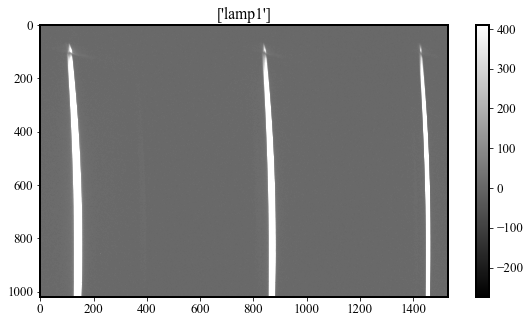

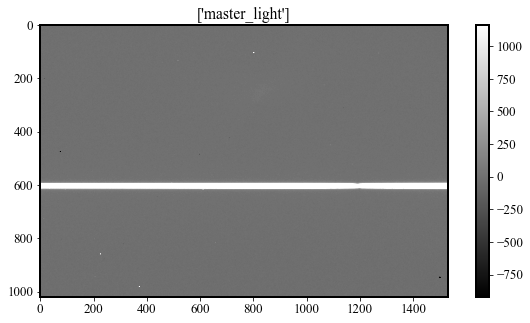

In [24]:
#######################################

dark1 = fits.getdata('DARK-5s-001.FIT')
dark2 = fits.getdata('DARK-5s-002.FIT')
dark3 = fits.getdata('DARK-5s-003.FIT')


master_dark_lamp = imcombine_median( (dark1, dark2, dark3) )
#######################################

lamp1_1 = fits.getdata('lamp2-5s-001.FIT')
lamp1_2 = fits.getdata('lamp2-5s-002.FIT')
lamp1_3 = fits.getdata('lamp2-5s-003.FIT')


lamp1 = imcombine_median( (lamp1_1, lamp1_2, lamp1_3) ) - master_dark_lamp

imshow(lamp1)


########################################

dark1 = fits.getdata('DARK-180s-001.FIT')
dark2 = fits.getdata('DARK-180s-002.FIT')
dark3 = fits.getdata('DARK-180s-003.FIT')

master_dark = imcombine_median( (dark1, dark2, dark3) )


#######################################

light1 = fits.getdata('vega-180s-001.FIT') - master_dark
light2 = fits.getdata('vega-180s-002.FIT') - master_dark
light3 = fits.getdata('vega-180s-003.FIT') - master_dark
light4 = fits.getdata('vega-180s-004.FIT') - master_dark

master_light = imcombine_Sum_4(light1, light2, light3, light4)

########################################

imshow(master_light)


angle = 0.0035943413955467187


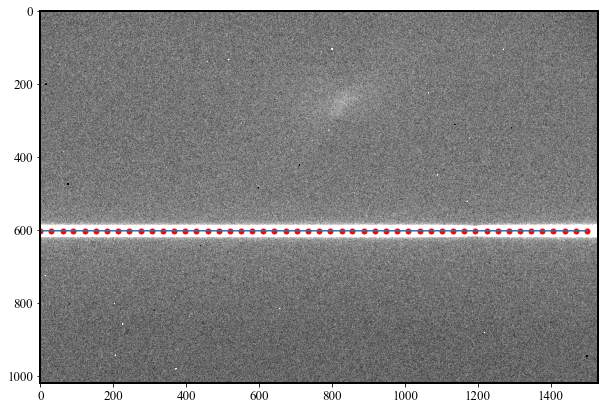

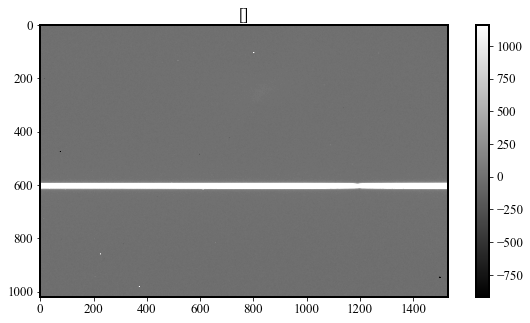

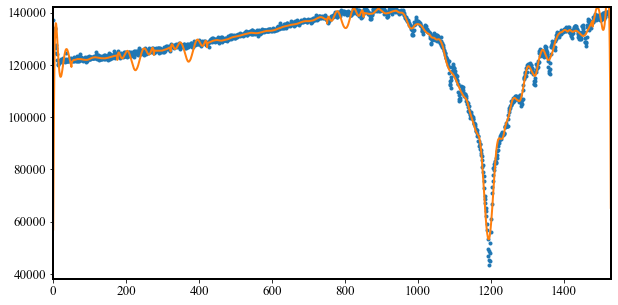

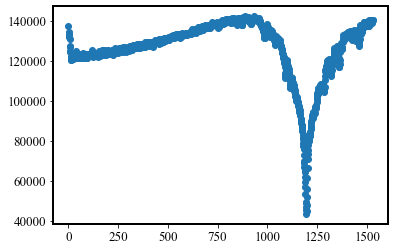

In [25]:
def makeSpectra(master_light):

    # - - Extracts 1D spectrum from 2D image                                                    - - #
    # - - Parameters: master_light -> ndarray; the 2D image that we use to extract the spectrum - - #
    # - - Returns:    spectra -> array-like; extracted 1D spectrum                              - - #
    # - -             angle -> float; the angle between the spectrograph slit and the camera    - - #
    
    spec_col = []
    spec_row = []
    number_points = 50
    imageLen = np.shape(master_light)[1]
    
    for i in range(number_points):
        medcol = np.median([
                            master_light[:, int((len(master_light[0]) * i / number_points))], 
                            master_light[:, int((len(master_light[0]) * i / number_points) + 1)],
                            master_light[:, int((len(master_light[0]) * i / number_points) - 1)],
                            master_light[:, int((len(master_light[0]) * i / number_points) + 2)],
                            master_light[:, int((len(master_light[0]) * i / number_points) - 2)]
                                                                        ], axis=0) 
        
        
        mean = sliceIndices(medcol)
        spec_row = np.append(spec_row, np.mean(mean))
        spec_col = np.append(spec_col, int((len(master_light[0]) * i / number_points)))

    # ^ ^ Още шано работи на Христо, виж после ^ ^ #


        
    coefs = np.polyfit(spec_col, spec_row, 1)


    plt.figure(figsize = (10,10))
    plt.plot(spec_col, spec_row, 'o', markersize = 5, color = 'r')
    plt.imshow(master_light, vmin = -100, vmax = 100, cmap = 'gray')
    plt.plot(spec_col, [PolyEval(x, coefs) for x in spec_col])

    angle = np.arctan(coefs[0]) * 180 / np.pi

    print('angle = ' + str(angle))

    ml_rot = rotate(master_light, angle)

    # - - Find angle by the first coefficient of the line that is fit through the points


    imshow(ml_rot) # Show rotated image
    col_ind, spectra = np.zeros((len(ml_rot[0]), 2)), np.zeros(len(ml_rot[0]))
    len_rowsa = len(ml_rot[0])
    for u in range(1, len_rowsa - 1):
        col_ind[u] = sliceIndices(ml_rot[:, u])

        spectra[u] = np.sum(ml_rot[int(col_ind[u][0]) : int(col_ind[u][1]), u])
    
    spec_fit = savgol_filter(spectra, 101, 8)
    outliers = np.where(abs(spec_fit - spectra) > 10000)[0]
    for i in outliers:
        spectra[i] = np.median(np.concatenate((spectra[i - 5 : i - 1], spectra[i + 1 : i + 5])))

    
    
    plt.figure(figsize = (10, 5))    
    plt.plot(spectra, 'o', markersize = 3)
    plt.plot(spec_fit, '-', lw = 2)
    plt.axis(xmin = 0, xmax = imageLen, ymax = np.max(spectra))

    plt.figure()

    plt.plot(spectra, 'o')

    #print(outliers)

    #print(spectra[spectra < 20000][0 : 3])

    #np.where(spectra < 21000)[0]
    return (spectra,angle)


spectra, angle = makeSpectra(master_light)


[ 135  864 1451]
[139, 868, 1456]


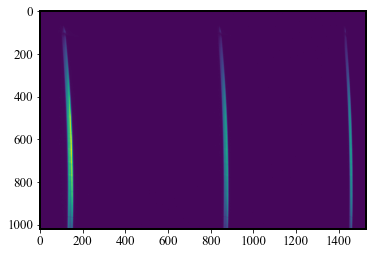

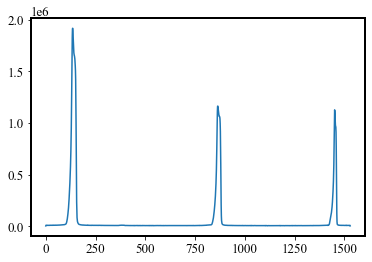

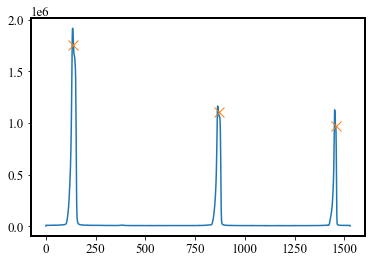

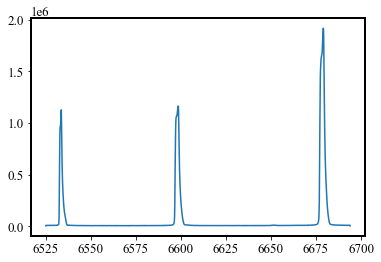

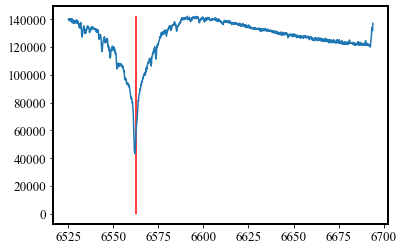

In [26]:
def fitLambdaBounds(peaks, lengths, imageSize):
  
  # - - Extracts 1D spectrum from 2D image - - #
  # - - Parameters: peaks -> array-like; list of ints corresponding to columns where signal peaks - - #
  # - -             lengths -> array-like; list of wavelengths corresponding to the columns in peaks - - #
  # - -             imageSize -> int; the number of columns in a 2D image / number of entries in a 1D array containing signal- - #
  # - - Returns:    (firstLambda, lastLambda) -> pair of floats; wavelengths corresponding to - - #
  # - -                                          first and last columns - - #

  # - - Returns wavelengths corresponding to first and last columns - - #

  z = np.polyfit(peaks, lengths, 1)
  firstLambda, lastLambda = PolyEval(0, z), PolyEval(imageSize, z)
  return (firstLambda, lastLambda)

def calibrateLamp(lampImage, angle, lampLambdas):

  # - - Find wavelengths corresponding to each column in a 2D image                                                           - - #
  # - - Parameters: lampImage -> ndarray; 2D image of the calibration lamp                                                    - - #
  # - -             lengths -> array-like; list of wavelengths corresponding to the columns in peaks                          - - #
  # - -             imageSize -> int; the number of columns in a 2D image / number of entries in a 1D array containing signal - - #
  # - - Returns:    lambdas -> array-like; a list of wavelengths for each corresponding column in the 2D image                - - #

  lampIm = rotate(lampImage, angle)

  plt.figure()
  plt.imshow(lampIm)

  # ^ ^ Rotated Lamp Image ^ ^ #

  #lampLambdasHa = [6678.276, 6598.953, 6532.882] #6506.528, 6266.495
  #lampLambdas = [6217.281, 6163.594, 6143.063]
  # ^ ^ Some additional lamp lines used during Beli Brezi 2021 ^ ^ #
  lamp_threshold = 500000

  lampColSums = np.sum(lampIm, axis = 0)

  plt.figure()
  plt.plot(lampColSums)

  peaks, _ = find_peaks(lampColSums, lamp_threshold, distance = 50)
  med_len = 7
  print(peaks)
  peaks = [np.where(lampColSums == find_nearest(lampColSums[ peaks[0] - med_len : peaks[0] + med_len ],
                                                np.median(lampColSums[ peaks[0] - med_len : peaks[0] + med_len ]) ))[0],

          np.where(lampColSums == find_nearest(lampColSums[ peaks[1] - med_len : peaks[1] + med_len ],
                                                np.median(lampColSums[ peaks[1] - med_len : peaks[1] + med_len ]) ))[0],

          np.where(lampColSums == find_nearest(lampColSums[ peaks[2] - med_len : peaks[2] + med_len ],
                                                np.median(lampColSums[ peaks[2] - med_len : peaks[2] + med_len ]) ))[0] ]

  # ^ ^ Христо е писал някакви магии тук??? ^ ^ #

  peaks = list( map(lambda x: int(x), peaks) )

  # ^ ^ Round peaks to integers so they can correspond to image columns ^ ^ #

  print(peaks)

  # ^ ^ Намиране на пиковете на сумите по колони ^ ^ #

  plt.figure()
  plt.plot(lampColSums)
  plt.plot(peaks, lampColSums[peaks], 'x', markersize = 10)

  imageLen = len(lampColSums)

  startLambdaLength, endLambdaLength = fitLambdaBounds(peaks, lampLambdas, imageLen)

  # ^ ^ Find lambdas corresponding to first and last columns ^ ^ #

  lambdas = np.linspace(startLambdaLength, endLambdaLength, imageLen)

  # ^ ^ Find corresponding lambda for each column in the image ^ ^ #

  plt.figure()
  plt.plot(lambdas, lampColSums)

  plt.figure()
  plt.plot(lambdas, spectra)

  vlines(6562.8, 0, np.max(spectra), colors = 'r')
  # ^ ^ Check absorption line with Halpha wavelength ^ ^ #
  
  return lambdas

lambdas = calibrateLamp(lamp1, angle, lampLambdas = [6678.276, 6598.953, 6532.882])

In [27]:
# - - Идеи за нормиране - - #

#c = savgol_filter(spectra, 1201 , 2)

#spectra_fitted = [spectra[i] / c[i] for i in np.arange(0, imageLen-1, 1)]

#plt.plot(spectra_fitted)

<ipython-input-28-fe569c70affe>:24: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']
No handles with labels found to put in legend.


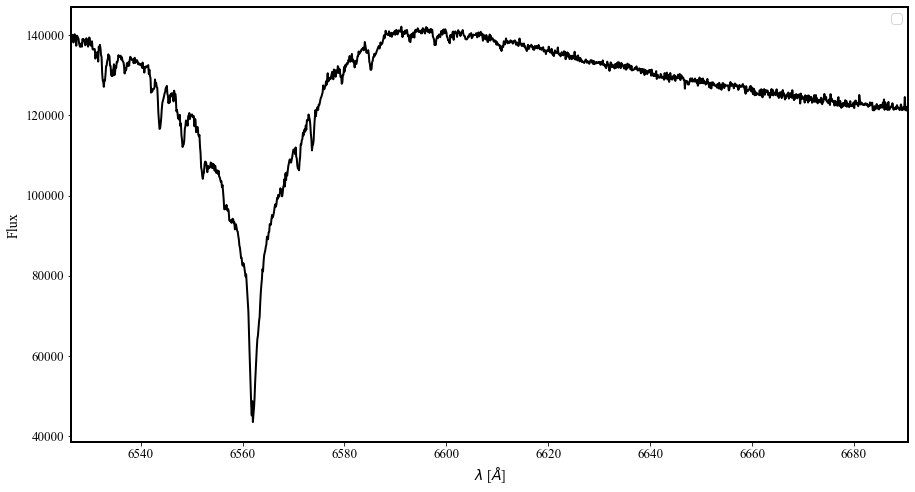

In [28]:

def plot1DSpectra(signal, lambdas, startCut = 0, endCut = 0, saveToCSV = False, csvName = ""):

  # - - Plot 1D spectra - - #
  # - - Parameters: signal -> array-like; array containing spectrum signal                                  - - #
  # - -             lambdas -> array-like; list of wavelengths corresponding to each entry in signal        - - #
  # - -             startCut -> int; determines number of columns to be cut from the left part of signal    - - #
  # - -             endCut -> int; determines the number of columns to be cut from the right part of signal - - #
  # - -             saveToCSV -> boolean; if set to True, signal and lambdas will be saved to a csv file    - - #
  # - -             csvName -> string; if saveToCSV is set to True, this will be the name of the csv file   - - #
  # - - Returns:    nothing - - #

  # - - If you want to save your data to csv, set saveToCSV to Тrue and set file name in csvName
  # - - startCut determines number of columns to be cut from the left
  # - - endCut determines the number of columns to be cut from the right 

  plt.rcParams["font.family"] = "serif"
  plt.rcParams["font.serif"] = "Times New Roman"
  plt.rcParams["font.size"] = 13

  rc('text', usetex = False)
  rc('axes', linewidth = 2)
  rc('font')

  rcParams['text.latex.preamble'] = [r'\usepackage{sfmath}']

  
  lambdaInterval = lambdas[startCut: -endCut - 1]

  # ^ ^ Cut along the x axis according to parameters startCut and endCut ^ ^ #

  spectrum = zip(lambdaInterval, signal[startCut : -endCut - 1])
  dfa = pd.DataFrame(spectrum, columns = ['Lambda', 'Flux'])

  # ^ ^ Create DataFrame object containing our data ^ ^ #

  dfa.dropna(subset = ["Flux"], inplace = True) 


  plt.figure(figsize = (15,8))

  plt.plot(dfa['Lambda'], dfa['Flux'], '-', c = 'k', lw = 2)
  plt.axis( xmin = np.min(lambdaInterval), xmax = np.max(lambdaInterval) )
  plt.ylabel('Flux', fontsize = 14)
  plt.xlabel('$\lambda$ [$\AA$]', fontsize = 14)
  plt.legend()

  # ^ ^ Setting plot parameters ^ ^ #
   
  if(saveToCSV): dfa.to_csv(csvName + ".csv")

plot1DSpectra(spectra, lambdas, startCut = 30, endCut = 10, saveToCSV = True, csvName = "vega-spectrum")
